In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm

In [218]:
path_train = r"../train/"

In [219]:
TEST = True

test_wagnums = range(1, 1000)

test_start = pd.to_datetime('2023-01-01')
test_end = pd.to_datetime('2023-03-01')

dislok = pd.read_parquet(path_train + '/dislok_wagons.parquet').convert_dtypes()
dislok['plan_date'] = pd.to_datetime(dislok['plan_date'])

if TEST:
    dislok = dislok[(dislok['plan_date'] >= test_start) & (dislok['plan_date'] <= test_end)]
    dislok = dislok[dislok['wagnum'].isin(test_wagnums)]

freight_data = pd.read_parquet(path_train + '/freight_info.parquet').convert_dtypes()

dislok.fillna(pd.NA, inplace=True)

In [220]:
dislok.shape

(59853, 16)

In [221]:
absent_freights = set(dislok.fr_id.unique()) - set(freight_data.fr_id.unique())
print(f"Absent freights: {len(absent_freights)}")

for fr_id in absent_freights:
    values = {col: 0 for col in freight_data.columns}
    values['fr_id'] = fr_id
    freight_data = pd.concat([freight_data, pd.DataFrame([values])], ignore_index=True)

Absent freights: 3


In [222]:
absent_freights = set(dislok.fr_id.unique()) - set(freight_data.fr_id.unique())
assert len(absent_freights) == 0

In [223]:
dislok = dislok.merge(freight_data, on='fr_id')

In [224]:
del freight_data

In [225]:
dislok.shape

(59853, 24)

In [226]:
dislok.sample(5)

,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,...,last_fr_id,distance,fr_class,skoroport,naval,nasip,naliv,openvagons,soprovod,smerz
1938,2023-01-05,818,NaT,2020-03-30,0,2023-03-30,31,22,31,7908,...,5007,-1,1,0,0,0,0,0,0,0
38616,2023-02-26,551,NaT,2020-09-27,1,2023-09-27,31,8021,33,10829,...,1671,-1,2,0,0,0,0,0,0,0
23319,2023-02-17,681,2012-07-17,2021-05-21,0,2024-05-21,43,22,43,12055,...,4987,309,1,0,0,0,0,0,0,0
8112,2023-01-26,678,2012-07-12,2021-06-08,0,2024-06-08,42,22,42,11413,...,5058,-1,1,0,0,0,0,0,0,0
4231,2023-01-25,606,NaT,2019-06-24,1,2022-06-24,31,22,31,7880,...,429,-1,1,0,0,0,0,0,0,0


In [227]:
train_df = pd.read_csv(path_train +'/target/y_train.csv').convert_dtypes()
train_df['month'] = pd.to_datetime(train_df['month'])

if TEST:
    train_df = train_df[(train_df['month'] >= test_start) & (train_df['month'] <= test_end)]
    train_df = train_df[train_df['wagnum'].isin(test_wagnums)]

train_df.sample(5)

,wagnum,month,target_month,target_day
28439,800,2023-01-01,0,0
229264,269,2023-02-01,0,0
230353,389,2023-02-01,0,0
230639,339,2023-02-01,0,0
204224,862,2023-02-01,0,0


In [228]:
test_set = pd.read_csv(path_train +'/target/y_predict.csv').convert_dtypes()
wagnums_test = test_set.wagnum.unique()

print(f"Test set size: {len(test_set)}")

test_df = pd.DataFrame({'wagnum': wagnums_test, 'month': [pd.to_datetime('2023-03-01')] * len(wagnums_test)})

if TEST:
    test_df = test_df[test_df['wagnum'].isin(test_wagnums)]

print(len(test_df), train_df.wagnum.nunique())
test_df.sample(5)

Test set size: 33707
996 999


,wagnum,month
29575,178,2023-03-01
28504,679,2023-03-01
26492,377,2023-03-01
29996,88,2023-03-01
26429,413,2023-03-01


In [229]:
all_df = pd.concat([train_df, test_df], ignore_index=True)
all_df.isna().sum()

wagnum            0
month             0
target_month    996
target_day      996
dtype: int64

In [230]:
train_df.target_month.mean()

0.02456140350877193

In [231]:
import gc
gc.collect()

255

### Дислокация вагонов - сбор данных

In [232]:
dislok.columns

Index(['plan_date', 'wagnum', 'date_kap', 'date_dep', 'kod_vrab',
       'date_pl_rem', 'id_road_disl', 'st_id_dest', 'id_road_dest',
       'st_id_send', 'id_road_send', 'ost_prob', 'isload', 'fr_id',
       'last_fr_id', 'distance', 'fr_class', 'skoroport', 'naval', 'nasip',
       'naliv', 'openvagons', 'soprovod', 'smerz'],
      dtype='object')

In [233]:
dislok['days_to_pl_rem'] = (dislok['date_pl_rem'] - dislok['plan_date']).dt.days
dislok['another_road'] = dislok['id_road_dest'] != dislok['id_road_send']
dislok['last_rem_date'] = dislok[['date_kap', 'date_dep']].max(axis=1)
dislok['days_from_last_rem'] = (dislok['plan_date'] - dislok['last_rem_date']).dt.days
dislok = dislok.convert_dtypes()

In [234]:
dislok.sort_values(by='plan_date', inplace=True)

In [235]:
to_fill = ['ost_prob']

median_values = dislok[to_fill].median()
print(median_values)
print(f"Total nans: {dislok[to_fill].isna().sum()}")

dislok[to_fill] = dislok.groupby('wagnum')[to_fill].transform(lambda x: x.fillna(method='ffill'))
print(f"Total nans after ffill: {dislok[to_fill].isna().sum()}")

# dislok[to_fill] = dislok.groupby('wagnum')[to_fill].transform(lambda x: x.fillna(method='bfill'))
dislok[to_fill] = dislok.groupby('wagnum')[to_fill].transform(lambda x: x.fillna(median_values))

ost_prob    115197.0
dtype: float64
Total nans: ost_prob    2972
dtype: int64
Total nans after ffill: ost_prob    2972
dtype: int64


In [236]:
dislok['diff'] = -dislok.groupby('wagnum')['ost_prob'].diff()
dislok['diff'] = dislok['diff'].clip(lower=0)
dislok['diff'] = dislok['diff'].fillna(dislok['diff'].median())

In [237]:
import importlib
import add_roads
importlib.reload(add_roads)

from add_roads import add_roads
dislok = add_roads(dislok, path_train)

st_features = ['st_border_sign', 'st_sea_sign', 'st_river_sign', 'st_car_sign', 'st_ferry_sign', 'st_freigh_sign', 'opor_station_sign']
dislok.loc[:, st_features] = dislok.loc[:, st_features].fillna(0)

dislok.sample(5)

,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,...,st_id_x,road_id,st_id_y,st_border_sign,st_sea_sign,st_river_sign,st_car_sign,st_ferry_sign,st_freigh_sign,opor_station_sign
42207,2023-02-12,811,NaT,2021-06-21,0,2024-06-21,38,498,3,16008,...,498,3,16008,11,9,2,0,2,447,0
27891,2023-01-28,600,NaT,2019-10-08,1,2022-10-08,11,2606,11,3084,...,2606,5,3084,8,0,4,0,0,465,0
34467,2023-02-04,71,2020-08-09,2017-08-04,0,2023-08-09,44,12329,44,9546,...,12329,24,9546,6,18,5,1,2,317,0
19580,2023-01-20,44,2018-07-26,2021-07-27,0,2024-07-27,42,1953,11,11412,...,1953,5,11412,8,0,4,0,0,465,0
22812,2023-01-23,583,2022-05-25,2019-06-11,0,2025-05-25,15,10518,38,2641,...,10518,19,2641,3,0,6,2,0,208,0


In [238]:
dislok.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59853 entries, 0 to 59852
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   plan_date           59853 non-null  datetime64[ns]
 1   wagnum              59853 non-null  Int64         
 2   date_kap            17553 non-null  datetime64[ns]
 3   date_dep            59853 non-null  datetime64[ns]
 4   kod_vrab            59853 non-null  Int64         
 5   date_pl_rem         59853 non-null  datetime64[ns]
 6   id_road_disl        59853 non-null  Int64         
 7   st_id_dest          59853 non-null  Int64         
 8   id_road_dest        59853 non-null  Int64         
 9   st_id_send          59853 non-null  Int64         
 10  id_road_send        59853 non-null  Int64         
 11  ost_prob            59853 non-null  Int64         
 12  isload              59853 non-null  Int64         
 13  fr_id               59853 non-null  Int64     

In [239]:
from collections import Counter

distances = dict()
counter = Counter()

data = dislok[['st_id_send', 'st_id_dest', 'distance']]
data = data[data.distance != -1]

# Compute average distance between each pair of stations
data = data.to_numpy()

for st_id_send, st_id_dest, distance in tqdm(data):
    counter[(st_id_send, st_id_dest)] += 1
    distances[(st_id_send, st_id_dest)] = distances.get((st_id_send, st_id_dest), 0) + distance

for key in distances.keys():
    distances[key] /= counter[key]

  0%|          | 0/16498 [00:00<?, ?it/s]

In [240]:
data = data = dislok[['st_id_send', 'st_id_dest', 'distance']].to_numpy()
found = 0
for i in tqdm(range(len(data))):
    st_id_send, st_id_dest, distance = data[i]
    if distance == -1 and (st_id_send, st_id_dest) in distances:
        found += 1

print(f"Found: {found}")

  0%|          | 0/59853 [00:00<?, ?it/s]

Found: 36462


In [241]:
avg_distances = np.zeros(len(data))
for i in tqdm(range(len(data))):
    st_id_send, st_id_dest, distance = data[i]
    avg_distances[i] = distances.get((st_id_send, st_id_dest), np.nan)


dislok['avg_distance'] = avg_distances
dislok.avg_distance.fillna(dislok.avg_distance.mean(), inplace=True)

  0%|          | 0/59853 [00:00<?, ?it/s]

<Axes: ylabel='Frequency'>

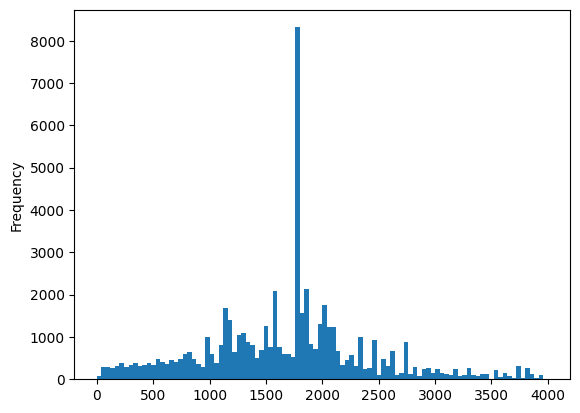

In [242]:
dislok['avg_distance'].plot.hist(bins=100, range=(0, 4000))

In [243]:
wagnum_subtables = {wagnum: table.copy() for wagnum, table in tqdm(dislok.groupby('wagnum'))}

  0%|          | 0/999 [00:00<?, ?it/s]

In [244]:
from itertools import product

intervals = [pd.DateOffset(days=5), pd.DateOffset(days=10), pd.DateOffset(days=30), pd.DateOffset(days=60)]
functions = {"isload": ['mean'], "diff": ['mean'], "another_road": ['max'],
              "avg_distance": ['max', 'min']}

fr_classes = ['skoroport', 'naval', 'nasip', 'naliv', 'openvagons', 'soprovod', 'smerz']
for fr_class in fr_classes:
    functions[fr_class] = ['mean']

st_features = ['st_border_sign', 'st_sea_sign', 'st_river_sign', 'st_car_sign', 'st_ferry_sign', 'st_freigh_sign', 'opor_station_sign']
for st_feature in st_features:
    functions[st_feature] = ['max', 'mean']

take_last_cols = ['date_kap', 'date_dep', 'kod_vrab', 'date_pl_rem', 'days_to_pl_rem', 'last_rem_date', 'days_from_last_rem', 'ost_prob']
rolling_cols = set()


for wagnum, table in tqdm(wagnum_subtables.items()):
    col_names = []
    cols = []
    for interval in intervals:
        for col, func_list in functions.items():
            for func in func_list:
                col_names.append(f"{interval.days}d_{col}_{func}")
                cols.append(getattr(table[col].rolling(interval.days), func)(engine='numba'))
                cols[-1].name = f"{interval.days}d_{col}_{func}"
                # table.loc[:, f"{interval.days}d_{col}_{func}"] = getattr(table[col].rolling(interval.days), func)(engine='numba')
                rolling_cols.add(f"{interval.days}d_{col}_{func}")

    table.loc[:, col_names] = pd.concat(cols, axis=1)

columns_to_add = list(rolling_cols) + take_last_cols

  0%|          | 0/999 [00:00<?, ?it/s]

In [245]:
wagnum_subtables[10][['plan_date', '30d_diff_mean', '5d_diff_mean', '10d_diff_mean', '60d_diff_mean', 'diff']].head(10)

,plan_date,30d_diff_mean,5d_diff_mean,10d_diff_mean,60d_diff_mean,diff
534,2023-01-01,NaN,NaN,NaN,NaN,0
1786,2023-01-02,NaN,NaN,NaN,NaN,363
2349,2023-01-03,NaN,NaN,NaN,NaN,217
3577,2023-01-04,NaN,NaN,NaN,NaN,0
4821,2023-01-05,NaN,197.4,NaN,NaN,407
5690,2023-01-06,NaN,378.4,NaN,NaN,905
6130,2023-01-07,NaN,417.0,NaN,NaN,556
7614,2023-01-08,NaN,535.0,NaN,NaN,807
8403,2023-01-09,NaN,709.6,NaN,NaN,873
9452,2023-01-10,NaN,726.2,461.8,NaN,490


In [246]:
columns_to_add

['60d_opor_station_sign_max',
 '5d_st_river_sign_mean',
 '60d_st_border_sign_mean',
 '60d_st_car_sign_max',
 '30d_st_car_sign_max',
 '60d_avg_distance_max',
 '5d_st_sea_sign_max',
 '30d_st_freigh_sign_mean',
 '10d_st_sea_sign_mean',
 '60d_st_freigh_sign_max',
 '10d_avg_distance_max',
 '60d_st_sea_sign_mean',
 '10d_opor_station_sign_mean',
 '10d_naliv_mean',
 '30d_diff_mean',
 '30d_st_border_sign_mean',
 '30d_st_freigh_sign_max',
 '60d_st_freigh_sign_mean',
 '30d_st_border_sign_max',
 '5d_opor_station_sign_max',
 '60d_st_ferry_sign_mean',
 '5d_st_ferry_sign_max',
 '10d_st_ferry_sign_mean',
 '60d_naval_mean',
 '10d_st_freigh_sign_mean',
 '5d_st_sea_sign_mean',
 '5d_skoroport_mean',
 '10d_st_border_sign_mean',
 '10d_opor_station_sign_max',
 '5d_st_freigh_sign_mean',
 '30d_opor_station_sign_mean',
 '60d_opor_station_sign_mean',
 '5d_openvagons_mean',
 '10d_st_car_sign_max',
 '60d_openvagons_mean',
 '30d_openvagons_mean',
 '5d_st_border_sign_max',
 '10d_diff_mean',
 '5d_diff_mean',
 '10d_st

In [247]:
all_df.sort_values(by=['month', 'wagnum'], inplace=True)

data = pd.concat([wagnum_subtables[wagnum] for wagnum in tqdm(wagnum_subtables.keys())])
data = data[columns_to_add + ['wagnum', 'plan_date']]
data.rename({'plan_date': 'month'}, axis=1, inplace=True)
all_df_new = all_df.merge(data, on=['month', 'wagnum'], how='left')
    

all_df_new.sample(5)

  0%|          | 0/999 [00:00<?, ?it/s]

,wagnum,month,target_month,target_day,60d_opor_station_sign_max,5d_st_river_sign_mean,60d_st_border_sign_mean,60d_st_car_sign_max,30d_st_car_sign_max,60d_avg_distance_max,...,60d_avg_distance_min,5d_nasip_mean,date_kap,date_dep,kod_vrab,date_pl_rem,days_to_pl_rem,last_rem_date,days_from_last_rem,ost_prob
1789,794,2023-02-01,0,0,NaN,4.0,NaN,NaN,0.0,NaN,...,NaN,0.0,NaT,2021-07-30,0,2024-07-30,545,2021-07-30,551,29228
2220,229,2023-03-01,<NA>,<NA>,3.0,4.0,7.800000,0.0,0.0,1879.835294,...,285.25,0.0,NaT,2020-04-18,1,2023-04-18,48,2020-04-18,1047,159325
694,695,2023-01-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaT,2021-04-01,0,2024-04-01,456,2021-04-01,640,74540
858,859,2023-01-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaT,2021-06-30,0,2023-06-30,180,2021-06-30,550,115197
2530,539,2023-03-01,<NA>,<NA>,0.0,3.0,4.183333,0.0,0.0,2729.371859,...,92.00,1.0,2022-02-25,2019-03-23,0,2025-02-25,727,2022-02-25,369,106694


In [248]:
all_df_new.month.unique()

<DatetimeArray>
['2023-01-01 00:00:00', '2023-02-01 00:00:00', '2023-03-01 00:00:00']
Length: 3, dtype: datetime64[ns]

### Тип владения вагоном - сбор данных

In [249]:
# For rows in wag_prob with repdate == 2023-02-28, add the same row with repdate == 2023-03-01

wag_prob = pd.read_parquet(path_train + '/wagons_probeg_ownersip.parquet').convert_dtypes()
print(wag_prob.shape)

rows = wag_prob[wag_prob['repdate'] == pd.to_datetime('2023-02-28')].copy()
rows['repdate'] = pd.to_datetime('2023-03-01')
wag_prob = pd.concat([wag_prob, rows], ignore_index=True)
print(wag_prob.shape)

wag_prob.sample(10)

(7193667, 8)
(7227374, 8)


,repdate,wagnum,ost_prob,manage_type,rod_id,reestr_state,ownership_type,month
7208943,2023-03-01,2054,<NA>,0,0,1,0,2
3024280,2022-09-24,11289,40779,0,1,1,0,9
464855,2022-08-22,14079,135899,0,1,1,0,8
3085815,2023-01-05,11665,14609,0,1,1,0,1
1271742,2022-11-25,26875,159722,0,1,1,0,11
2980965,2022-10-23,19594,148865,0,0,1,0,10
6814860,2023-02-20,30061,91854,1,1,1,0,2
206354,2023-01-06,13738,138163,0,1,1,0,1
231247,2022-09-03,8801,89619,0,0,1,0,9
5834169,2022-10-25,9798,94885,0,0,1,0,10


In [250]:
wag_prob_months = wag_prob[wag_prob.repdate.dt.day == 1].copy()
print(wag_prob_months.shape)

wag_prob_months.drop(['ost_prob', 'month'], axis=1, inplace=True)
wag_prob_months.rename({'repdate': 'month'}, axis=1, inplace=True)

all_df_new_ = all_df_new.merge(wag_prob_months, on=['month', 'wagnum'], how='left')
all_df_new_.sample(5)

(271267, 8)


,wagnum,month,target_month,target_day,60d_opor_station_sign_max,5d_st_river_sign_mean,60d_st_border_sign_mean,60d_st_car_sign_max,30d_st_car_sign_max,60d_avg_distance_max,...,kod_vrab,date_pl_rem,days_to_pl_rem,last_rem_date,days_from_last_rem,ost_prob,manage_type,rod_id,reestr_state,ownership_type
202,203,2023-01-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,1,2023-05-20,139,2020-05-20,956,36005,0,0,1,0
454,455,2023-01-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,1,2023-04-22,111,2020-04-22,984,35541,0,0,1,0
2279,288,2023-03-01,<NA>,<NA>,3.0,6.0,2.533333,0.0,0.0,2209.800000,...,1,2022-11-23,-98,2019-11-23,1194,145358,0,0,1,0
426,427,2023-01-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,1,2022-11-24,-38,2019-11-24,1134,158241,0,0,1,0
2345,354,2023-03-01,<NA>,<NA>,0.0,6.0,1.300000,0.0,0.0,4890.285714,...,1,2022-07-17,-227,2019-07-17,1323,135365,0,0,1,0


In [251]:
all_df_new = all_df_new_

### Характеристики вагонов - сбор данных

In [252]:
wag_param = pd.read_parquet(path_train + '/wag_params.parquet').convert_dtypes()
wag_param.columns

Index(['wagnum', 'model', 'rod_id', 'gruz', 'cnsi_gruz_capacity',
       'cnsi_volumek', 'tara', 'date_build', 'srok_sl', 'zavod_build',
       'date_iskl', 'cnsi_probeg_dr', 'cnsi_probeg_kr', 'kuzov', 'telega',
       'tormoz', 'tipvozd', 'tippogl', 'norma_km', 'ownertype'],
      dtype='object')

In [253]:
all_df_new = all_df_new.merge(wag_param, on=['wagnum'], how='left')
all_df_new.sample(5)

,wagnum,month,target_month,target_day,60d_opor_station_sign_max,5d_st_river_sign_mean,60d_st_border_sign_mean,60d_st_car_sign_max,30d_st_car_sign_max,60d_avg_distance_max,...,date_iskl,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype
504,505,2023-01-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,110,160,2,9,2,4,11,160000,0
2399,408,2023-03-01,<NA>,<NA>,3.0,8.0,4.85,2.0,0.0,2256.418605,...,NaT,110,160,2,9,2,4,3,160000,0
2111,120,2023-03-01,<NA>,<NA>,3.0,7.0,4.10,0.0,0.0,4749.250000,...,NaT,110,160,2,9,2,4,11,160000,0
1347,352,2023-02-01,0,0,NaN,4.0,NaN,NaN,0.0,NaN,...,NaT,110,160,2,9,2,6,11,160000,0
889,890,2023-01-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,110,160,2,9,2,7,12,160000,0


In [254]:
all_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2991 entries, 0 to 2990
Columns: 139 entries, wagnum to ownertype
dtypes: Float64(1), Int64(24), datetime64[ns](8), float64(104), string(2)
memory usage: 3.2 MB


/tmp/ipykernel_25136/2815582639.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_df_new['expected_srok_sl_y'] = (all_df_new['srok_sl'] - all_df_new['date_build']).dt.days / 365


<Axes: ylabel='Frequency'>

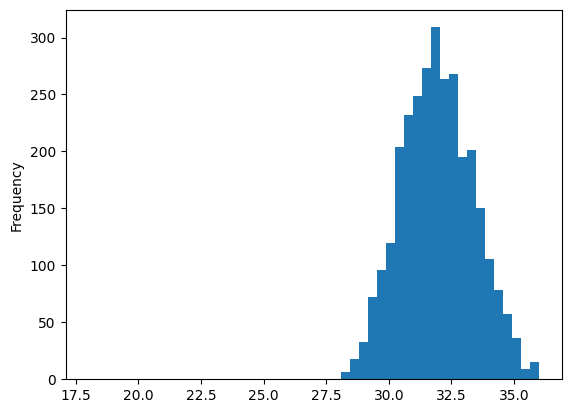

In [255]:
all_df_new['expected_srok_sl_y'] = (all_df_new['srok_sl'] - all_df_new['date_build']).dt.days / 365
all_df_new['expected_srok_sl_y'].plot.hist(bins=50, range=(18, 36))

In [256]:
all_df_new['expected_srok_sl_y_b'] = all_df_new['expected_srok_sl_y'].apply(lambda x: "short" if x <= 27.5 else "long")
all_df_new['expected_srok_sl_y_b'].value_counts()

/tmp/ipykernel_25136/2689697492.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_df_new['expected_srok_sl_y_b'] = all_df_new['expected_srok_sl_y'].apply(lambda x: "short" if x <= 27.5 else "long")


expected_srok_sl_y_b
long    2991
Name: count, dtype: int64

In [257]:
all_df_new['date_build_b'] = pd.cut(all_df_new['date_build'].dt.year, bins=[0, 2000, 2007, 2017, 2030])
all_df_new['date_build_b'].value_counts()

/tmp/ipykernel_25136/2605943646.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_df_new['date_build_b'] = pd.cut(all_df_new['date_build'].dt.year, bins=[0, 2000, 2007, 2017, 2030])


date_build_b
(2007, 2017]    2322
(0, 2000]        390
(2000, 2007]     279
(2017, 2030]       0
Name: count, dtype: int64

### Просмотр результата и сохранение

In [258]:
all_df_new.shape

(2991, 142)

In [259]:
all_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2991 entries, 0 to 2990
Columns: 142 entries, wagnum to date_build_b
dtypes: Float64(1), Int64(24), category(1), datetime64[ns](8), float64(105), object(1), string(2)
memory usage: 3.3+ MB


In [260]:
train_df_new = all_df_new[all_df_new.target_month.notna()]
test_df_new = all_df_new[all_df_new.target_month.isna()]

print(train_df_new.shape, test_df_new.shape)

(1995, 142) (996, 142)


In [261]:
train_df_new.to_csv(path_train + '/data/train_.csv', index=False)
test_df_new.to_csv(path_train + '/data/test_.csv', index=False)